<a href="https://colab.research.google.com/github/lgiesen/forest_height/blob/main/notebooks/boosted_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount ('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# the zipped data is uploaded in the root_path folder
root_path = 'drive/MyDrive/Colab Notebooks/data/'
path_images = f'{root_path}images/'
path_masks = f'{root_path}masks/'
color = "#01748F"
user = "lgiesen"
repo = "forest_height"
!git clone https://github.com/{user}/{repo}.git

Cloning into 'forest_height'...
remote: Enumerating objects: 655, done.
remote: Counting objects: 100% (307/307), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 655 (delta 169), reused 264 (delta 138), pack-reused 348
Receiving objects: 100% (655/655), 43.93 MiB | 20.79 MiB/s, done.
Resolving deltas: 100% (360/360), done.


In [117]:
%run /content/forest_height/src/load_data.py
%run /content/forest_height/src/evaluate_model.py
%run /content/forest_height/src/visualize_data.py

<Figure size 640x480 with 0 Axes>

In [20]:
def train_evaluate_model(model, dataset=["color_channels", "color_channels_ndvi", "ndvi", "all"]):
    for ds in dataset:
        print(ds)
        X_train, y_train, X_test, y_test = load_data(ds)
        # train model
        model.fit(X_train, y_train)
        # predict test set
        y_pred = gbr.predict(X_test)
        # evaluate model
        mae, mse, rmse, mape = evaluate_model(y_test, y_pred)

Fit Models on Color Channels and NDVI

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
# initialize model
gbr = GradientBoostingRegressor(n_estimators = 150, max_depth= 1, random_state=42)
train_evaluate_model(gbr)

color_channels
MAE: 9.305059657350041; MSE: 118.06186777046378; RMSE: 3.0504195870978212; MAPE: 1.6622092675980873
color_channels_ndvi
MAE: 9.306556172970568; MSE: 118.0552272890928; RMSE: 3.050664873920203; MAPE: 1.6625981186765517
ndvi
MAE: 9.458479575149543; MSE: 121.07508208398386; RMSE: 3.0754641235347786; MAPE: 1.6940980421433316
all


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 9.280223950467056; MSE: 115.27866317137055; RMSE: 3.0463459997950095; MAPE: 1.704318255605027


In [32]:
import joblib
def save_model(model, modelname, ds):
    train_evaluate_model(model, [ds])
    X_train, y_train, X_test, y_test = load_data(ds)
    %cd forest_height/models
    # save model
    joblib.dump(model, f'{modelname}.joblib')
    %cd ../../
    # load model with:
    # gbr = joblib.load("forest_height/models/boosted_trees.joblib")

In [33]:
save_model(gbr, "boosted_trees", "all")

all


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 9.280223950467056; MSE: 115.27866317137055; RMSE: 3.0463459997950095; MAPE: 1.704318255605027
/content/forest_height/models
/content


In [34]:
gbr = joblib.load("forest_height/models/boosted_trees.joblib")

Feature Importance

Feature: 0, Score: 0.03008
Feature: 1, Score: 0.00457
Feature: 2, Score: 0.24898
Feature: 3, Score: 0.00200
Feature: 4, Score: 0.10116
Feature: 5, Score: 0.05702
Feature: 6, Score: 0.05636
Feature: 7, Score: 0.15349
Feature: 8, Score: 0.03308
Feature: 9, Score: 0.15728
Feature: 10, Score: 0.09615
Feature: 11, Score: 0.02569
Feature: 12, Score: 0.02055
Feature: 13, Score: 0.00928
Feature: 14, Score: 0.00429


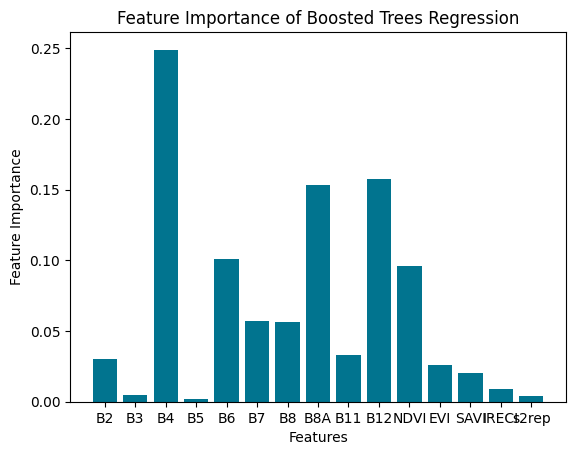

In [110]:
feature_importance(gbr, "Boosted Trees")

Predictions vs True Values

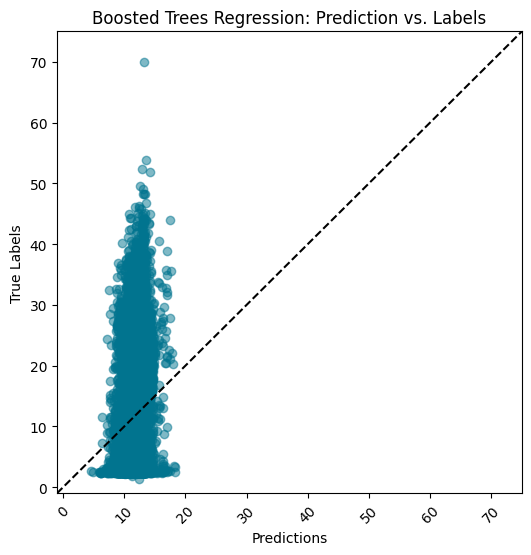

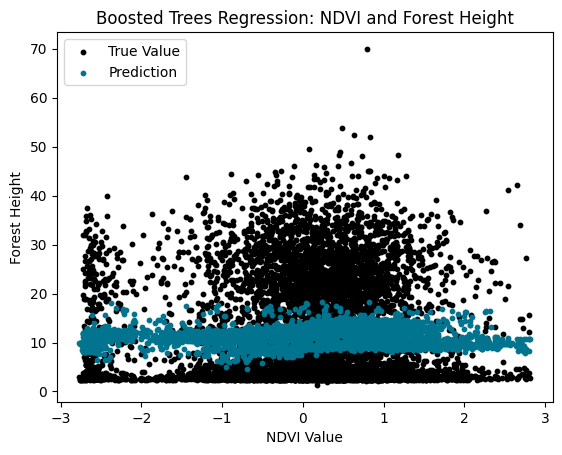

In [109]:
pred_vs_true(gbr, "Boosted Trees")

The random boosted trees regression is simply the average dataset tree height of ~13m. It performs poorly for lower and higher tree heights and is unable to predict tree heights, which deviate from the mean.

Predict exemplary image

In [65]:
%run forest_height/src/generate_data.py
%run forest_height/src/predict_data.py

In [113]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


def load_img(filepath, features):
    X = np.load(filepath)
    color_channels, width, height = X.shape
    Xr = X.reshape(color_channels,-1).transpose()
    assert len(X.shape) == 3
    color_channels, width, height = X.shape
    Xr = np.reshape(Xr, (width*height, color_channels))
    Xr = pd.DataFrame(Xr, columns = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'])
    if "NDVI" in features:
        # get NDVI value
        Xr = calculate_ndvi(Xr)
        if features == ["NDVI"]:
            Xr = Xr["NDVI"]
    if "VI" in features:
        Xr = calculate_VIs(Xr)
        if features == ["VI"]:
            vi_cols = ["EVI", "SAVI", "IRECI", "s2rep"]
            Xr = X_VI[vi_cols]
        elif features == ["NDVI", "VI"]:
            Xr = Xr[["NDVI", "EVI", "SAVI", "IRECI", "s2rep"]]
    ceiling = 2000
    # counteract high reflection values of clouds
    Xr[Xr > ceiling] = ceiling
    X[X > ceiling] = ceiling
    # counteract significant negative vegetation indices
    Xr[Xr < -1*ceiling] = -1*ceiling
    X[X < -1*ceiling] = -1*ceiling
    scaler = StandardScaler()
    Xr = scaler.fit_transform(Xr)
    return X, Xr, (color_channels, width, height)

def pred_img(filepath, features, model, plot_img=True, scale=True):
    pred = model.predict(Xr)
    pred = pred.transpose().reshape(1, width, height)
    if plot_img:
        tree_height_2d = pred[0]
        plot(X)
        plot(tree_height_2d)

In [114]:
X, Xr, (color_channels, width, height) = load_img(filepath=f'{path_images}{get_files(path_images)[10]}',
    features=['color_channels', 'NDVI', 'VI'])

In [115]:
np.amin(Xr), np.amax(Xr)

(-430.25919116898615, 336.336770564792)

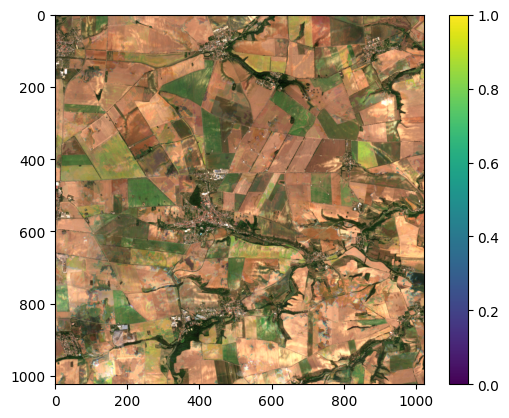

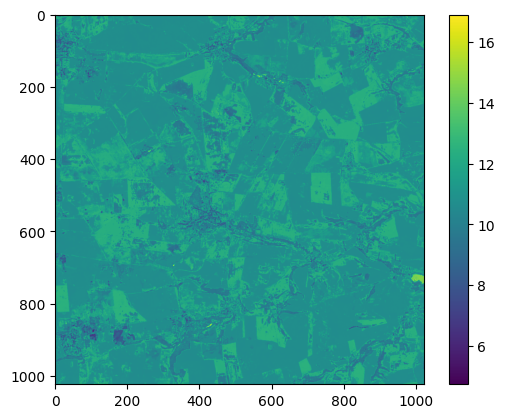

In [118]:
pred_img(
    filepath=f'{path_images}{get_files(path_images)[10]}',
    features=['color_channels', 'NDVI', 'VI'],
    model=gbr)